# Import packages

In [3]:

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
if Path.cwd().parts[-1] != 'Multifirefly-Project':
    if Path.cwd().parts[-1] != 'notebooks':
        os.chdir('..')
    from add_path import find_path
    current_path = find_path()
    os.chdir(current_path)

from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.neural_analysis_by_topic.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.neural_analysis_by_topic.planning_and_neural import planning_neural_class, planning_neural_utils
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

Changed the directory to 'Multifirefly-Project'.
Added /Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods to the path.
done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retrieve data

In [2]:
# add columns not in pn.behav_all_data to all_planning_info, merging by point_index

# need to make sure their point_index match though....raise a warning if there's point_index in all_planning_info but not in pn.behav_all_data

## debug

In [ ]:
# general_utils.check_na_in_df(df = pn.y_var_lags, col = 'point_index', raise_warning = True)


No NA values found in DataFrame


(Empty DataFrame
 Columns: [index_0, nxt_ff_angle_0, nxt_ff_distance_0, nxt_arc_curv_0, nxt_opt_arc_curv_0, nxt_opt_arc_dheading_0, time_rel_to_stop_0, traj_curv_0, cur_ff_angle_0, cur_ff_distance_0, cur_arc_curv_0, cur_opt_arc_curv_0, cur_opt_arc_dheading_0, segment_0, target_index_0, cur_ff_rel_x_0, cur_ff_rel_y_0, nxt_ff_rel_x_0, nxt_ff_rel_y_0, angle_from_m_before_stop_to_cur_ff_0, angle_from_m_before_stop_to_nxt_ff_0, angle_from_cur_ff_landing_to_nxt_ff_0, target_cluster_last_seen_angle_to_boundary_frozen_0, monkey_x_smr_0, trial_0, target_y_0, RDz_0, min_visible_ff_distance_0, cum_distance_since_target_last_seen_0, target_angle_0, eye_world_speed_0, gaze_mky_view_y_l_0, time_0, target_last_seen_distance_0, monkey_x_target_last_seen_0, target_cluster_has_disappeared_for_last_time_dummy_0, min_abs_ff_angle_boundary_0, monkey_y_0, monkey_ddv_0, crossing_boundary_0, min_abs_visible_ff_angle_boundary_0, gaze_mky_view_angle_l_0, gaze_world_y_0, monkey_y_target_last_seen_0, cum_distance

## get data

In [4]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"

In [4]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"

In [5]:
# pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
# pn.get_behav_data(exists_ok=False)

In [ ]:
ref_point_mode='time after cur ff visible'
ref_point_value=0.1
normalize = False
eliminate_outliers = False
use_curvature_to_ff_center = False
curv_of_traj_mode = 'distance'
window_for_curv_of_traj=[-25, 25]
truncate_curv_of_traj_by_time_of_capture = True

pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(both_ff_across_time_df_exists_ok=True)
pn.get_x_and_y_data_for_modeling(exists_ok=True)

print('x_var.shape:', pn.x_var.shape)
print('y_var.shape:', pn.y_var.shape)
print('y_var_reduced.shape:', pn.y_var_reduced.shape)

In [9]:
pn.get_x_and_y_data_for_modeling()

0.48% of rows are dropped in all_planning_info due to having missing values
binned_spikes_df.shape: (241149, 17)
self.x_var.shape: (32636, 16)
self.y_var.shape: (32636, 23)
Getting y_var_reduced...
Loaded y_var_reduced from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/pn_y_var_reduced.csv
Getting y_var_lags_reduced...
Loaded y_var_lags_reduced from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/pn_y_var_lags_reduced.csv


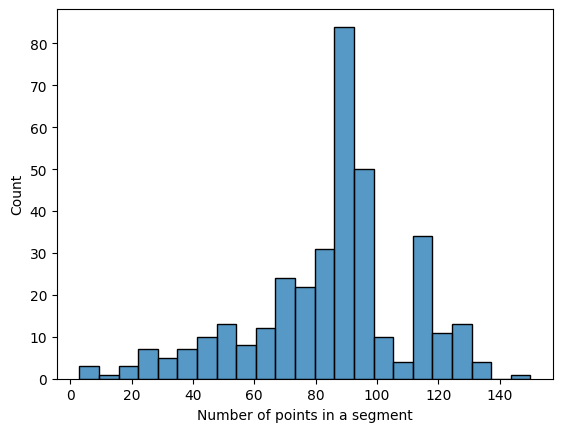

In [26]:
sns.histplot(pn.y_var.groupby('segment').count()['index'])
plt.xlabel('Number of points in a segment')
plt.show()

In [57]:
reload(neural_data_modeling)

<module 'neural_data_analysis.neural_analysis_tools.model_neural_data.neural_data_modeling' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/neural_data_analysis/neural_analysis_tools/model_neural_data/neural_data_modeling.py'>

In [20]:
pn.y_var.columns.tolist()

['index',
 'nxt_ff_angle',
 'nxt_ff_distance',
 'nxt_arc_curv',
 'nxt_opt_arc_curv',
 'nxt_opt_arc_dheading',
 'time_rel_to_stop',
 'traj_curv',
 'cur_ff_angle',
 'cur_ff_distance',
 'cur_arc_curv',
 'cur_opt_arc_curv',
 'cur_opt_arc_dheading',
 'bin',
 'segment',
 'target_index',
 'cur_ff_rel_x',
 'cur_ff_rel_y',
 'nxt_ff_rel_x',
 'nxt_ff_rel_y',
 'angle_from_m_before_stop_to_cur_ff',
 'angle_from_m_before_stop_to_nxt_ff',
 'angle_from_cur_ff_landing_to_nxt_ff',
 'target_cluster_last_seen_angle_to_boundary_frozen',
 'monkey_x_smr',
 'trial',
 'target_y',
 'RDz',
 'min_visible_ff_distance',
 'cum_distance_since_target_last_seen',
 'target_angle',
 'eye_world_speed',
 'gaze_mky_view_y_l',
 'time',
 'target_last_seen_distance',
 'monkey_x_target_last_seen',
 'target_cluster_has_disappeared_for_last_time_dummy',
 'min_abs_ff_angle_boundary',
 'monkey_y',
 'monkey_ddv',
 'crossing_boundary',
 'min_abs_visible_ff_angle_boundary',
 'gaze_mky_view_angle_l',
 'gaze_world_y',
 'monkey_y_target_

## clearly I need to further select relevant features from y_var

In [ ]:
pn.reduce_y_var_lags(exists_ok=False)

In [56]:
pn.y_var.shape

(32636, 23)

In [9]:
pn.both_ff_across_time_df.columns

Index(['index', 'nxt_ff_angle', 'nxt_ff_distance', 'nxt_arc_curv',
       'nxt_opt_arc_curv', 'nxt_opt_arc_dheading', 'time_rel_to_stop',
       'traj_curv', 'cur_ff_angle', 'cur_ff_distance', 'cur_arc_curv',
       'cur_opt_arc_curv', 'cur_opt_arc_dheading', 'stop_point_index',
       'point_index', 'bin', 'segment', 'target_index', 'cur_ff_rel_x',
       'cur_ff_rel_y', 'nxt_ff_rel_x', 'nxt_ff_rel_y'],
      dtype='object')

In [10]:
pn.all_planning_info.columns

Index(['index', 'nxt_ff_angle', 'nxt_ff_distance', 'nxt_arc_curv',
       'nxt_opt_arc_curv', 'nxt_opt_arc_dheading', 'time_rel_to_stop',
       'traj_curv', 'cur_ff_angle', 'cur_ff_distance',
       ...
       'RDy', 'target_last_seen_angle', 'bin_start_time', 'monkey_angle',
       'valid_view_point_l', 'valid_view_point', 'target_angle_to_boundary',
       'any_ff_visible', 'while_last_seeing_target_cluster', 'num_visible_ff'],
      dtype='object', length=116)

In [ ]:
# pn.both_ff_across_time_df.to_csv('temp_both_ff_across_time_df.csv')

In [58]:
pn.get_x_and_y_data_for_modeling()

0.48% of rows are dropped in all_planning_info due to having missing values
binned_spikes_df.shape: (241149, 17)
self.x_var.shape: (32636, 16)
self.y_var.shape: (32636, 23)
Getting y_var_reduced...
Loaded y_var_reduced from all_monkey_data/planning_and_neural/monkey_Bruno/data_0330/pn_y_var_reduced.csv


ValueError: could not broadcast input array from shape (117,17) into shape (117,16)

In [51]:
pn.x_var.shape

(32636, 17)

In [50]:
pn.y_var.shape

(32636, 23)

In [ ]:
pn.reduce_y_var_lags(exists_ok=False)

Getting y_var_lags_reduced...
Computing reduced y_var_lags...

====================Dropping features with high VIF for each feature====================
Processing feature 1/16
Iter 1: Dropped nxt_ff_angle_4 (VIF: 110.6)
Iter 2: Dropped nxt_ff_angle_2 (VIF: 110.5)
Iter 3: Dropped nxt_ff_angle_-1 (VIF: 110.4) instead of nxt_ff_angle_0 (VIF: 110.4) because drop_lag_0_last=True
Iter 4: Dropped nxt_ff_angle_-3 (VIF: 110.3)
Iter 5: Dropped nxt_ff_angle_1 (VIF: 82.9)
Iter 6: Dropped nxt_ff_angle_-4 (VIF: 82.8)
Iter 7: Dropped nxt_ff_angle_3 (VIF: 45.9)
Iter 8: Dropped nxt_ff_angle_-2 (VIF: 45.8)
Iter 9: Dropped nxt_ff_angle_5 (VIF: 10.2) instead of nxt_ff_angle_0 (VIF: 21.4) because drop_lag_0_last=True
Iter 10: Dropped nxt_ff_angle_-5 (VIF: 10.0) instead of nxt_ff_angle_0 (VIF: 10.0) because drop_lag_0_last=True
After iterative dropping, the column with the highest VIF is nxt_ff_angle_0 with VIF 0.00
10 columns out of 11 of *nxt_ff_angle* dropped: [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
Iter 1: 

## see features

In [ ]:
pn.y_var.columns

Index(['index', 'nxt_ff_angle', 'nxt_ff_distance', 'nxt_arc_curv',
       'nxt_opt_arc_curv', 'nxt_opt_arc_dheading', 'time_rel_to_stop',
       'traj_curv', 'cur_ff_angle', 'cur_ff_distance', 'cur_arc_curv',
       'cur_opt_arc_curv', 'cur_opt_arc_dheading', 'bin',
       'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to_nxt_ff',
       'angle_from_cur_ff_landing_to_nxt_ff'],
      dtype='object')

In [7]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

In [ ]:
stop

## check final VIF

In [ ]:
pn.y_var_reduced.columns

Index(['nxt_arc_curv', 'time_rel_to_stop', 'traj_curv', 'cur_ff_angle',
       'cur_arc_curv', 'cur_opt_arc_dheading', 'bin',
       'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to_nxt_ff',
       'angle_from_cur_ff_landing_to_nxt_ff'],
      dtype='object')

In [11]:
vif_df = drop_high_vif_vars.get_vif_df(pn.y_var_reduced)
vif_df

,feature,vif
5,cur_opt_arc_dheading,2.90000
8,angle_from_m_before_stop_to_nxt_ff,2.80000
2,traj_curv,2.70000
3,cur_ff_angle,2.20000
9,angle_from_cur_ff_landing_to_nxt_ff,2.10000
0,nxt_arc_curv,2.00000
6,bin,1.90000
1,time_rel_to_stop,1.90000
4,cur_arc_curv,1.70000
7,angle_from_m_before_stop_to_cur_ff,1.30000


In [134]:
pn.y_var_lags_reduced.columns

Index(['angle_from_cur_ff_landing_to_nxt_ff_0',
       'angle_from_m_before_stop_to_cur_ff_0',
       'angle_from_m_before_stop_to_nxt_ff_0', 'bin', 'cur_arc_curv_-5',
       'cur_arc_curv_0', 'cur_arc_curv_5', 'cur_ff_angle_-5', 'cur_ff_angle_5',
       'cur_ff_distance_0', 'cur_opt_arc_dheading_0', 'index_0',
       'nxt_arc_curv_0', 'traj_curv_0'],
      dtype='object')

In [69]:
vif_df = drop_high_vif_vars.get_vif_df(pn.y_var_lags_reduced)
vif_df

,feature,vif
5,cur_opt_arc_dheading,2.90000
7,angle_from_m_before_stop_to_nxt_ff,2.80000
2,traj_curv,2.70000
3,cur_ff_angle,2.20000
8,angle_from_cur_ff_landing_to_nxt_ff,2.10000
0,nxt_arc_curv,2.00000
9,bin,1.90000
1,time_rel_to_stop,1.90000
4,cur_arc_curv,1.70000
6,angle_from_m_before_stop_to_cur_ff,1.30000


## check correlations in y_var_lags

In [ ]:
# sort pn.y_var_lags by column str a to z
pn.y_var_lags2 = pn.y_var_lags.reindex(sorted(pn.y_var_lags.columns), axis=1)

# # sort pn.y_var_lags by column str z to a
# pn.y_var_lags_reduced = pn.y_var_lags_reduced.reindex(sorted(pn.y_var_lags_reduced.columns, reverse=True), axis=1)

In [ ]:
pn.y_var_lags2.iloc[:, :10].corr()

,angle_from_cur_ff_landing_to_nxt_ff_-1,angle_from_cur_ff_landing_to_nxt_ff_-2,angle_from_cur_ff_landing_to_nxt_ff_-3,angle_from_cur_ff_landing_to_nxt_ff_-4,angle_from_cur_ff_landing_to_nxt_ff_-5,angle_from_cur_ff_landing_to_nxt_ff_0,angle_from_cur_ff_landing_to_nxt_ff_1,angle_from_cur_ff_landing_to_nxt_ff_2,angle_from_cur_ff_landing_to_nxt_ff_3,angle_from_cur_ff_landing_to_nxt_ff_4
angle_from_cur_ff_landing_to_nxt_ff_-1,1.00000,0.99255,0.98510,0.97765,0.97019,0.99255,0.98511,0.97766,0.97022,0.96278
angle_from_cur_ff_landing_to_nxt_ff_-2,0.99255,1.00000,0.99255,0.98510,0.97764,0.98510,0.97766,0.97021,0.96277,0.95533
angle_from_cur_ff_landing_to_nxt_ff_-3,0.98510,0.99255,1.00000,0.99255,0.98509,0.97765,0.97021,0.96276,0.95532,0.94788
angle_from_cur_ff_landing_to_nxt_ff_-4,0.97765,0.98510,0.99255,1.00000,0.99255,0.97020,0.96275,0.95531,0.94787,0.94043
angle_from_cur_ff_landing_to_nxt_ff_-5,0.97019,0.97764,0.98509,0.99255,1.00000,0.96275,0.95530,0.94786,0.94041,0.93297
angle_from_cur_ff_landing_to_nxt_ff_0,0.99255,0.98510,0.97765,0.97020,0.96275,1.00000,0.99255,0.98511,0.97767,0.97023
angle_from_cur_ff_landing_to_nxt_ff_1,0.98511,0.97766,0.97021,0.96275,0.95530,0.99255,1.00000,0.99256,0.98511,0.97767
angle_from_cur_ff_landing_to_nxt_ff_2,0.97766,0.97021,0.96276,0.95531,0.94786,0.98511,0.99256,1.00000,0.99256,0.98512
angle_from_cur_ff_landing_to_nxt_ff_3,0.97022,0.96277,0.95532,0.94787,0.94041,0.97767,0.98511,0.99256,1.00000,0.99256
angle_from_cur_ff_landing_to_nxt_ff_4,0.96278,0.95533,0.94788,0.94043,0.93297,0.97023,0.97767,0.98512,0.99256,1.00000


# LR

In [137]:
# With x var lags
pn.y_var_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_lags_reduced, pn.y_var_lags_reduced)
pn.y_var_lr_df

,feature,r,r_squared,p_values,significant
0,bin,0.74733,0.55850,0.00000,True
1,cur_ff_distance_0,0.64358,0.41419,0.00000,True
2,cur_opt_arc_dheading_0,0.54799,0.30030,0.00000,True
3,traj_curv_0,0.53353,0.28466,0.00000,True
4,index_0,0.51814,0.26847,0.00000,True
5,cur_ff_angle_5,0.48112,0.23148,0.00000,True
6,cur_ff_angle_-5,0.45915,0.21082,0.00000,True
7,cur_arc_curv_0,0.43575,0.18988,0.00000,True
8,cur_arc_curv_5,0.43121,0.18594,0.00000,True
9,cur_arc_curv_-5,0.42876,0.18384,0.00000,True


In [135]:
# no lags on x var
pn.y_var_no_lag_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.x_var_reduced, pn.y_var_reduced)
pn.y_var_no_lag_lr_df

,feature,r,r_squared,p_values,significant
0,bin,0.34594,0.11968,0.00000,True
1,time_rel_to_stop,0.28502,0.08124,0.00000,True
2,cur_opt_arc_dheading,0.25445,0.06474,0.00000,True
3,traj_curv,0.23169,0.05368,0.00000,True
4,cur_ff_angle,0.19974,0.03990,0.00000,True
5,cur_arc_curv,0.17847,0.03185,0.00000,True
6,nxt_arc_curv,0.16909,0.02859,0.00000,True
7,angle_from_cur_ff_landing_to_nxt_ff,0.15279,0.02334,0.00000,True
8,angle_from_m_before_stop_to_nxt_ff,0.14467,0.02093,0.00000,True
9,angle_from_m_before_stop_to_cur_ff,0.14001,0.01960,0.00000,True


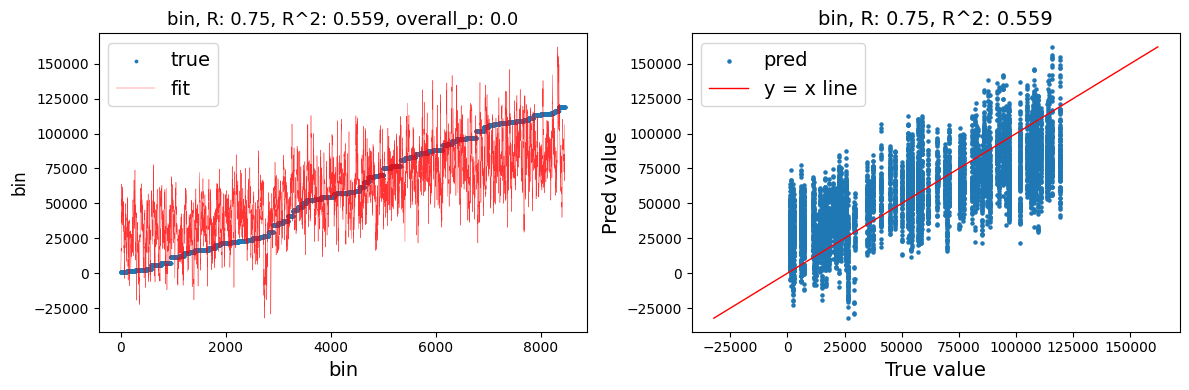

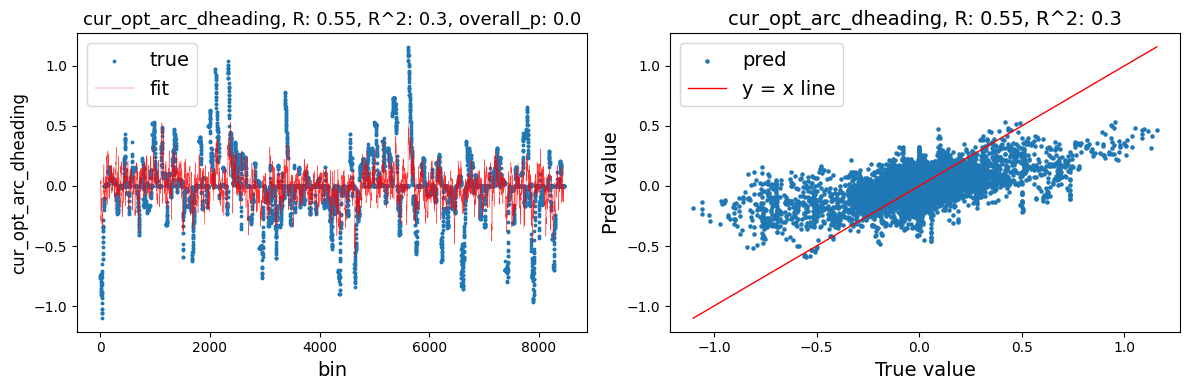

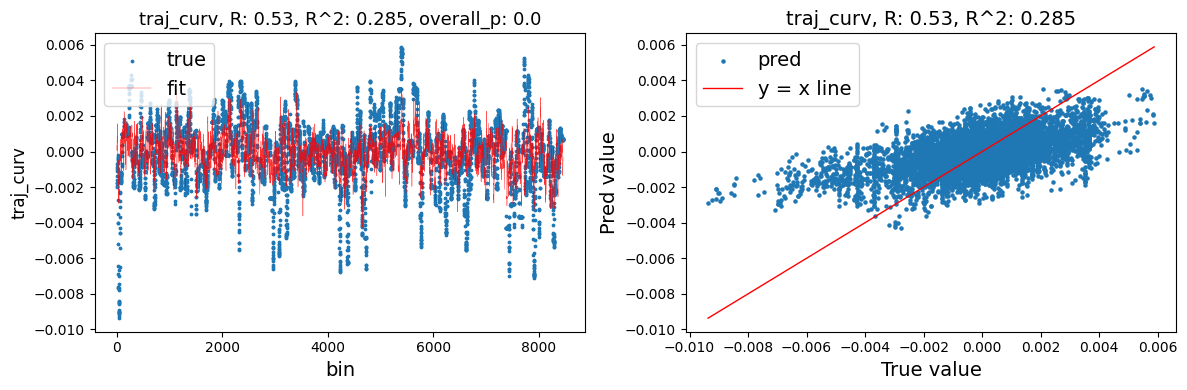

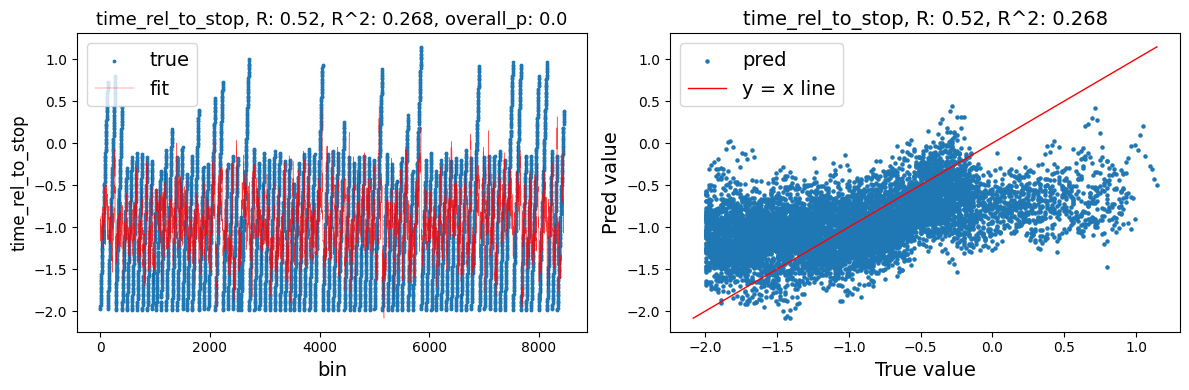

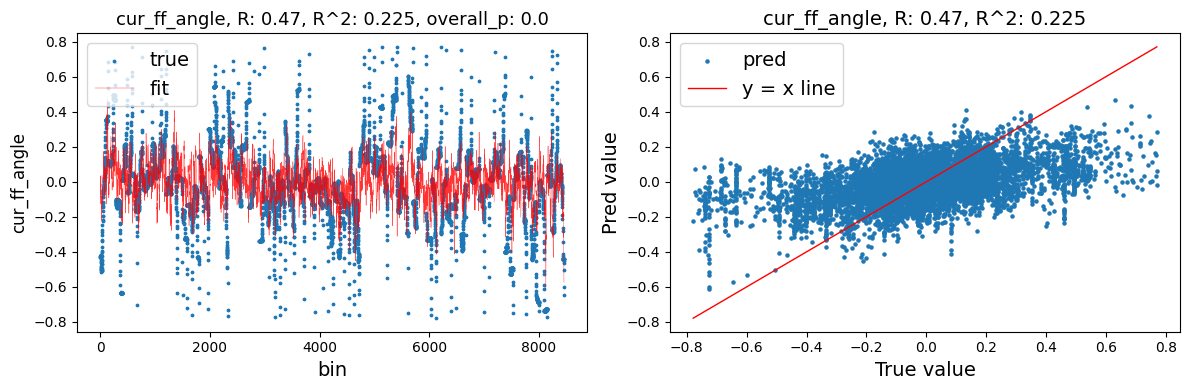

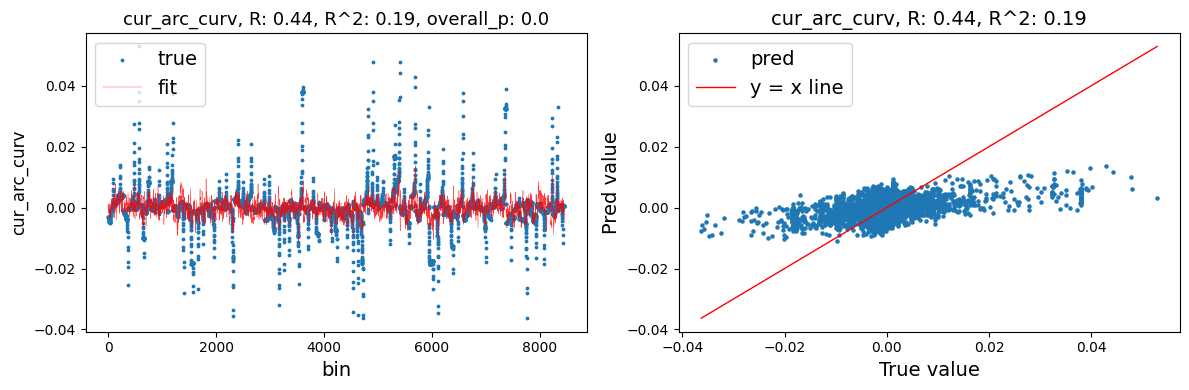

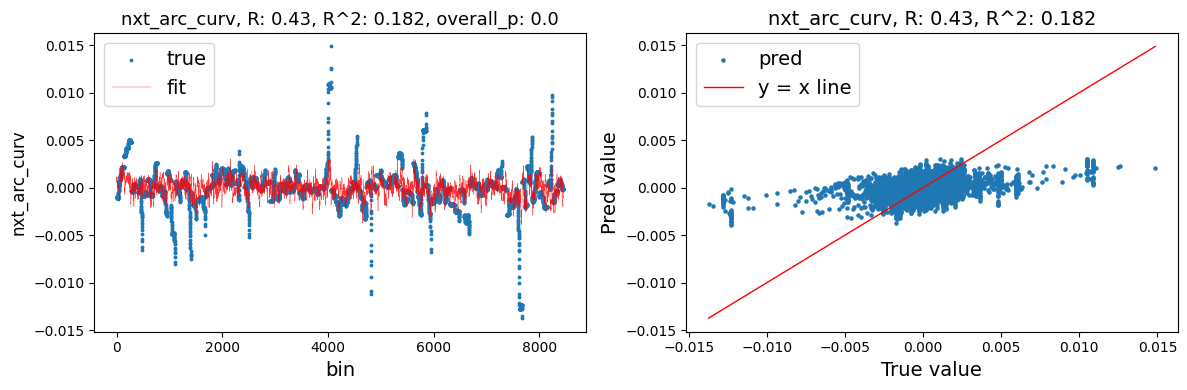

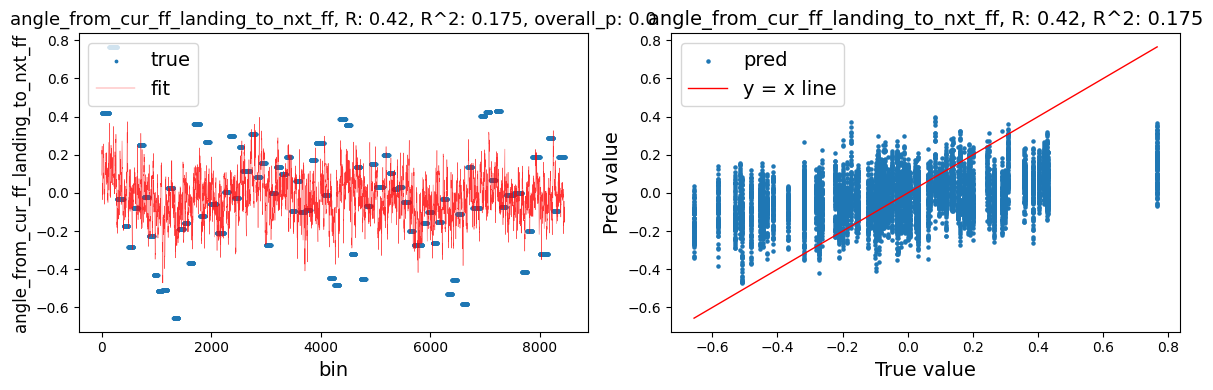

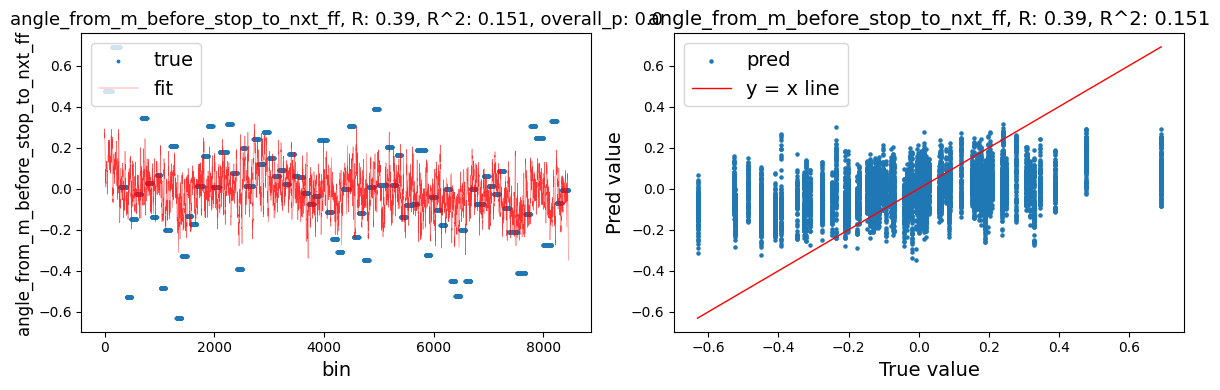

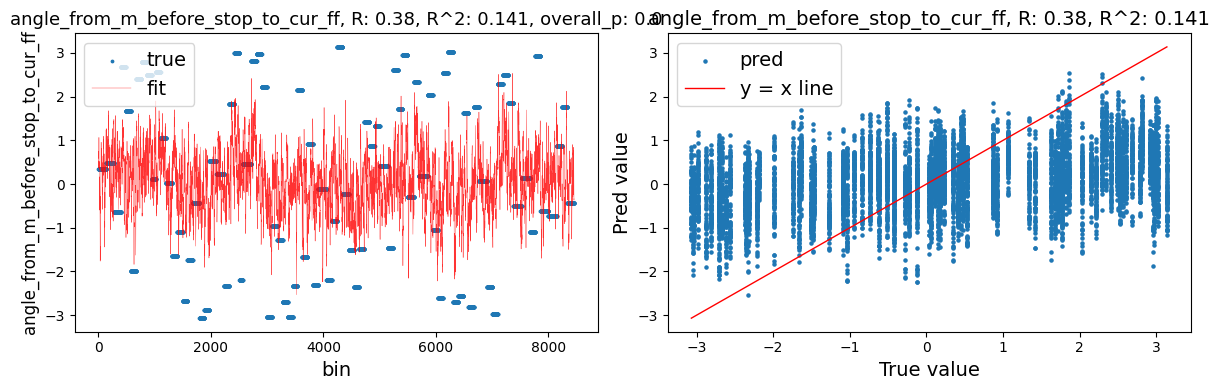

In [34]:
x_var = pn.x_var_lags_reduced
y_var = pn.y_var_reduced

# Plot linear regression on X and y
max_plot_number = 10
count = 0
bins_to_plot = range(len(pn.y_var))

for i, column in enumerate(pn.y_var_lr_df.feature.values): # so that features are plotted in the order of correlation
    if i >= max_plot_number:
        break
    plot_neural_data.plot_regression(y_var, column, x_var, bins_to_plot=None, min_r_squared_to_plot=0.3)
    # if i == 3:
    #     break

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.35319 0.30212 0.23695 0.19923 0.16833 0.15385 0.13603 0.12467 0.11017
 0.10621]
% Shared Variance: [0.12474 0.09127 0.05615 0.03969 0.02833 0.02367 0.0185  0.01554 0.01214
 0.01128]


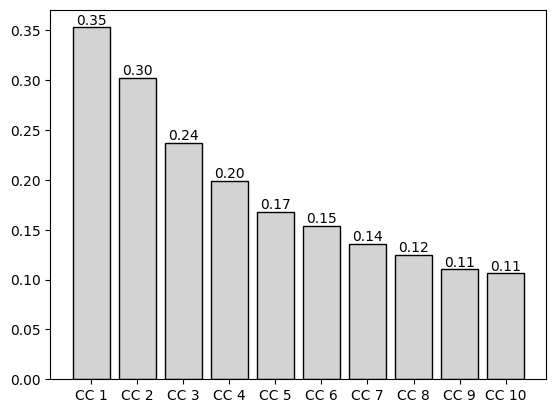

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.75247 0.67723 0.55874 0.48508 0.45654 0.43133 0.40216 0.40094 0.38288
 0.36528]
% Shared Variance: [0.56621 0.45864 0.31219 0.2353  0.20842 0.18604 0.16174 0.16075 0.1466
 0.13343]


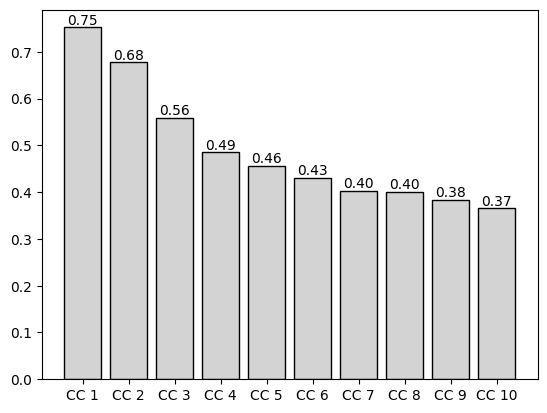

pn.x_var_lags.shape: (8458, 946)
pn.y_var_lags_reduced.shape: (8458, 14)


In [ ]:
cca_no_lag = cca_class.CCAclass(X1=pn.x_var_reduced, X2=pn.y_var_reduced, lagging_included=False)
cca_no_lag.conduct_cca()

cca_lags = cca_class.CCAclass(X1=pn.x_var_lags_reduced.drop(columns='bin', errors='ignore'), X2=pn.y_var_lags_reduced, lagging_included=True)
# for all columns that end with _0, rename them to the column name without the _0
cca_lags.X2.columns = cca_lags.X2.columns.str.replace('_0', '')
cca_lags.conduct_cca()


print(f'pn.x_var_lags.shape: {pn.x_var_lags.shape}')
print(f'pn.y_var_lags_reduced.shape: {pn.y_var_lags_reduced.shape}')

cca_inst = cca_lags

## compare lag vs no lag

In [140]:
can_load_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
can_load_df[f'with_lags'] = cca_lags.canon_corr
can_load_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert can_load_df to long format
can_load_df_long = pd.melt(can_load_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

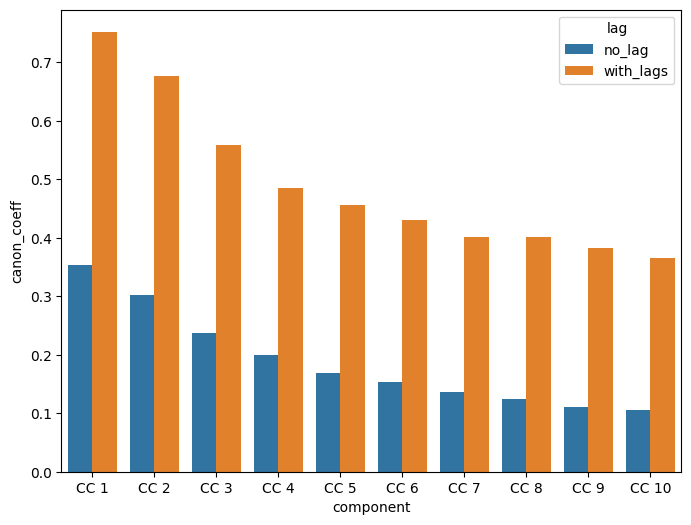

In [141]:
# make a sns bar plot on can_load_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=can_load_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [142]:
# choose no lag
cca_inst = cca_no_lag

In [143]:
# choose lags
cca_inst = cca_lags

## test for p values

In [9]:
cca_inst.test_for_p_values()

# Heatmap of loadings

## X1 loadings

In [ ]:
# cca_inst.plot_X1_loadings()

## X2 loadings

In [159]:
pn.y_var_lags_reduced.columns

Index(['angle_from_cur_ff_landing_to_nxt_ff',
       'angle_from_m_before_stop_to_cur_ff',
       'angle_from_m_before_stop_to_nxt_ff', 'bin', 'cur_arc_curv_-5',
       'cur_arc_curv', 'cur_arc_curv_5', 'cur_ff_angle_-5', 'cur_ff_angle_5',
       'cur_ff_distance', 'cur_opt_arc_dheading', 'index', 'nxt_arc_curv',
       'traj_curv'],
      dtype='object')

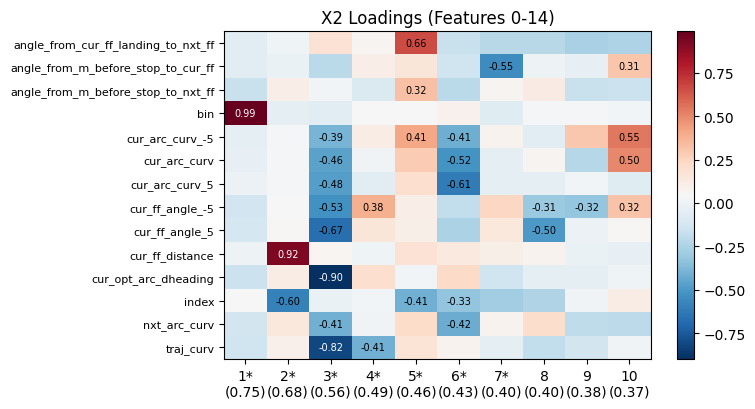

In [ ]:
cca_inst.plot_X2_loadings()

In [ ]:
pn.y_var_lags_reduced.corr()

,angle_from_cur_ff_landing_to_nxt_ff,angle_from_m_before_stop_to_cur_ff,angle_from_m_before_stop_to_nxt_ff,bin,cur_arc_curv_-5,cur_arc_curv,cur_arc_curv_5,cur_ff_angle_-5,cur_ff_angle_5,cur_ff_distance,cur_opt_arc_dheading,index,nxt_arc_curv,traj_curv
angle_from_cur_ff_landing_to_nxt_ff,1.00000,0.05374,0.70910,-0.05888,0.04636,0.04429,0.04774,0.03653,0.02641,-0.04716,-0.04724,0.06746,0.40390,0.07807
angle_from_m_before_stop_to_cur_ff,0.05374,1.00000,0.02391,0.00120,0.39087,0.39713,0.36182,0.39877,0.34476,0.01479,0.18239,-0.00318,0.09272,0.11844
angle_from_m_before_stop_to_nxt_ff,0.70910,0.02391,1.00000,-0.19605,0.04777,0.04680,0.05427,0.07161,0.07435,-0.02244,0.02194,0.05699,0.60718,0.15035
bin,-0.05888,0.00120,-0.19605,1.00000,-0.02654,-0.02616,-0.02566,-0.12824,-0.12015,-0.03389,-0.07670,0.04785,-0.14643,-0.11080
cur_arc_curv_-5,0.04636,0.39087,0.04777,-0.02654,1.00000,0.73644,0.58990,0.58454,0.45387,0.01239,0.30543,0.02384,0.21849,0.32775
cur_arc_curv,0.04429,0.39713,0.04680,-0.02616,0.73644,1.00000,0.73648,0.59255,0.50889,0.01028,0.31175,0.02344,0.20683,0.37605
cur_arc_curv_5,0.04774,0.36182,0.05427,-0.02566,0.58990,0.73648,1.00000,0.48134,0.58694,0.02477,0.26549,-0.00648,0.17787,0.36515
cur_ff_angle_-5,0.03653,0.39877,0.07161,-0.12824,0.58454,0.59255,0.48134,1.00000,0.73708,0.03798,0.52193,-0.00940,0.27186,0.40279
cur_ff_angle_5,0.02641,0.34476,0.07435,-0.12015,0.45387,0.50889,0.58694,0.73708,1.00000,0.02009,0.53731,-0.01673,0.25471,0.51470
cur_ff_distance,-0.04716,0.01479,-0.02244,-0.03389,0.01239,0.01028,0.02477,0.03798,0.02009,1.00000,0.02164,-0.84516,0.01365,0.01884


# Canonical Variate scatterplots

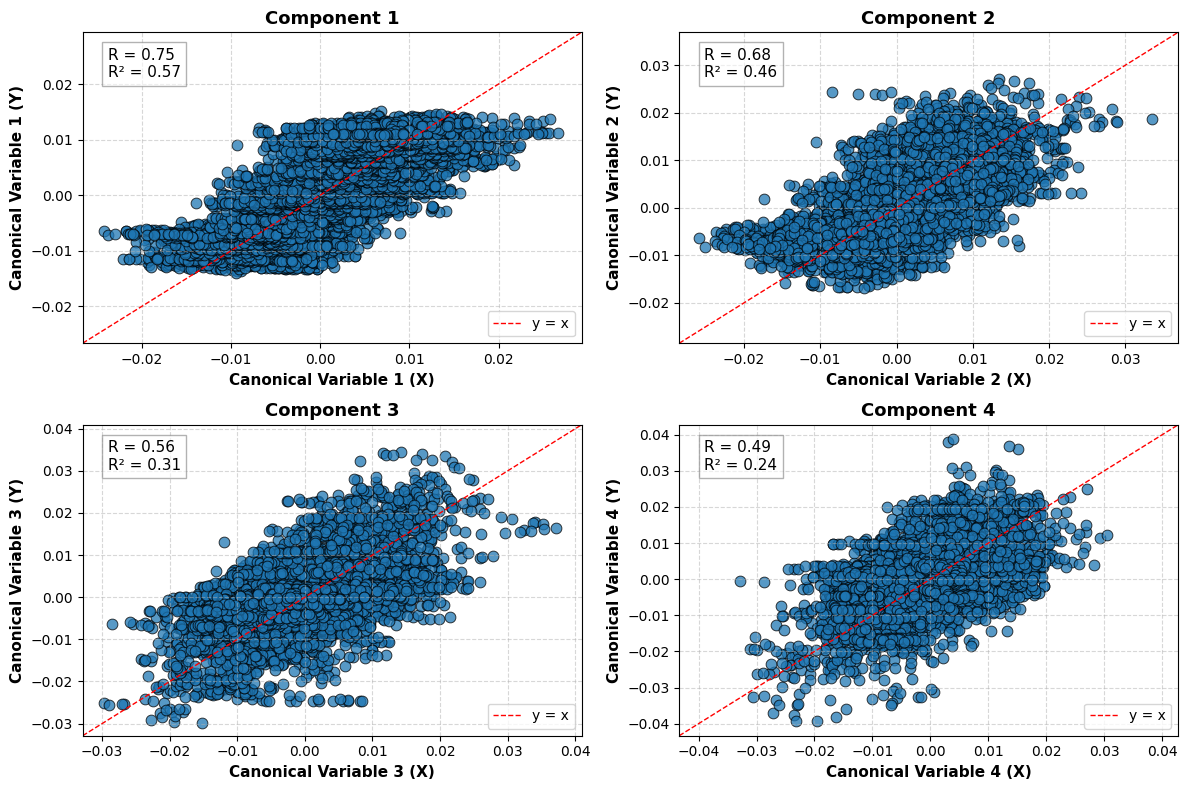

In [145]:
components=range(1, 5)
cca_plotting.plot_cca_component_scatter(cca_inst.X1_c, cca_inst.X2_c, components=components, show_y_eq_x=True)


# Transform vars (e.g. use basis functions)

In [147]:
cca_no_lag.X2_tf_df = transform_vars.transform_behav_data(cca_no_lag.X2)
cca_lags.X2_tf_df = transform_vars.transform_behav_data(cca_lags.X2)

In [148]:
# If need to use the data
cca_inst = cca_lags
X1_df = cca_inst.X1_sc_df
X2_df = cca_inst.X2_tf_df


# Lags vs no lag & train vs test

## Get data

In [ ]:
combined_cross_view_df, combined_can_load_df = cca_cv_utils.combine_cv_results(cca_no_lag, cca_lags, n_components=7, reg=0.1, n_splits=7)

Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components


/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Training CCA, kernel = None, regularization = 0.1000, 3 components
Training CCA, kernel = None, regularization = 0.1000, 3 components


## cross-view X1

In [ ]:
# dataset_name = 'X1'
# cross_view_sub = combined_cross_view_df[combined_cross_view_df['dataset'] == dataset_name]
# cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(cross_view_sub, dataset_name, mode='lag_offset')


## cross-view X2

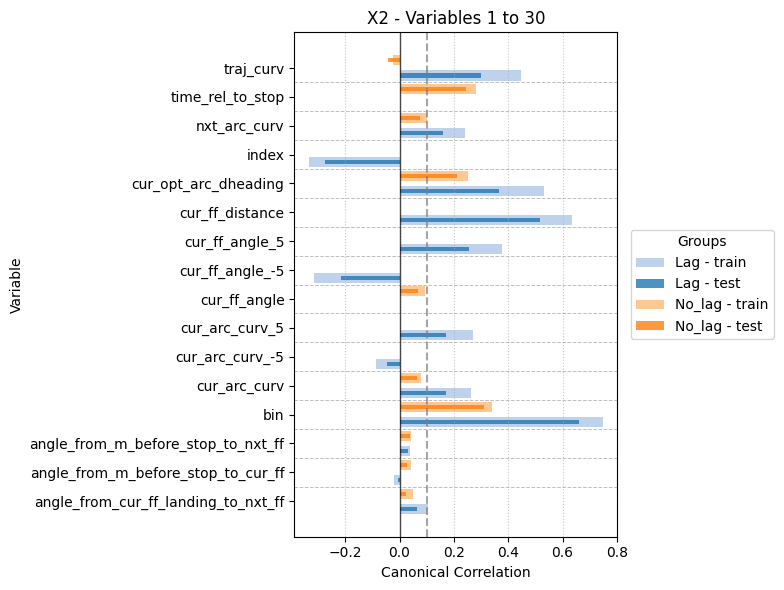

In [ ]:
dataset_name = 'X2'
cross_view_sub = combined_cross_view_df[combined_cross_view_df['dataset'] == dataset_name]
cca_plot_lag_vs_no_lag.plot_cca_lag_vs_nolag_and_train_vs_test(cross_view_sub, dataset_name, mode='lag_offset')


# Just train vs test

## cross-view X1

In [ ]:
# filter_significant = True
# sort_by_significance = True
# significance_threshold = 4
# whether_lag = 'lag'

# combined_cross_view_df_sub = combined_cross_view_df[combined_cross_view_df['whether_lag'] == whether_lag]

# # X1
# cca_plot_cv.plot_cca_cv_results(combined_cross_view_df_sub, data_type='X1',
#                                     filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


## cross-view X2

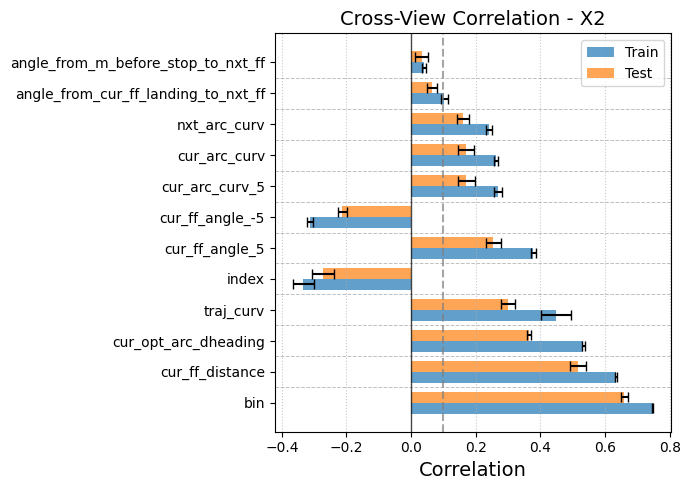

In [58]:
filter_significant = True
sort_by_significance = True
significance_threshold = 1
whether_lag = 'lag'

combined_cross_view_df_sub = combined_cross_view_df[combined_cross_view_df['whether_lag'] == whether_lag]

# X2
cca_plot_cv.plot_cca_cv_results(combined_cross_view_df_sub, data_type='X2',
                                    filter_significant=filter_significant, sort_by_significance=sort_by_significance, significance_threshold=significance_threshold)


# Appendix

## Compare columns in behav_data (target_decoder) and final_behavioral_data (neural_vs_behavioral_class)

In [ ]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"
pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
pn.get_behav_data(exists_ok=False)

In [ ]:
data_item = neural_vs_behavioral_class.NeuralVsBehavioralClass(raw_data_folder_path=raw_data_folder_path)
data_item.streamline_preparing_neural_and_behavioral_data()

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
When take out monkey subset for GUAT, 144 clusters out of 254 are too close to the target or the last target. Those clusters are filtered out.
The number of new trials that are used to separate stop clusters is 470
Retrieved all_trial_patterns
Retrieved pattern_frequencies
Retrieved all_trial_features
Retrieved feature_statistics
Retrieved scatter_around_target_df


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/neural_data_analysis/neural_analysis_by_topic/neural_vs_behavioral/prep_monkey_data.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  monkey_info_in_bins = monkey_info_in_bins.bfill(


Retrieved target_df
Retrieved target_cluster_df
Window width changed from 0.25 to 0.26 to make it odd
Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df_0p02.csv


In [ ]:
# Columns in pn.behav_data_all but not in data_item.final_behavioral_data
only_in_pn = set(pn.behav_data_all.columns) - set(data_item.final_behavioral_data.columns)
print("Columns only in pn.behav_data_all:")
only_in_pn = np.array(sorted(only_in_pn))
print(only_in_pn)
print('\n \n')

# Columns in data_item.final_behavioral_data but not in pn.behav_data_all
final_behavioral_data_columns = data_item.final_behavioral_data.columns
# remove all 'avg_bin_' prefix
final_behavioral_data_columns = [col.replace('avg_bin_', '') for col in final_behavioral_data_columns]
only_in_data_item = set(final_behavioral_data_columns) - set(pn.behav_data_all.columns)
print("Columns only in data_item.final_behavioral_data:")
only_in_data_item = np.array(sorted(only_in_data_item))
print(only_in_data_item)

Columns only in pn.behav_data_all:
['bin_end_time' 'bin_start_time' 'capture_target_dummy'
 'crossing_boundary' 'cum_distance' 'cum_distance_since_target_last_seen'
 'cum_distance_when_target_last_seen' 'current_target_caught_time'
 'd_heading_since_target_last_seen' 'delta_distance'
 'distance_from_monkey_pos_target_last_seen' 'dt' 'eye_world_speed'
 'gaze_mky_view_angle' 'gaze_mky_view_angle_l' 'gaze_mky_view_angle_r'
 'gaze_mky_view_x_l' 'gaze_mky_view_x_r' 'gaze_mky_view_y_l'
 'gaze_mky_view_y_r' 'gaze_world_x_l' 'gaze_world_x_r' 'gaze_world_y_l'
 'gaze_world_y_r' 'last_target_caught_time'
 'monkey_angle_target_last_seen' 'monkey_dw_smr' 'monkey_speed_smr'
 'monkey_speeddummy' 'monkey_x' 'monkey_x_smr' 'monkey_x_target_last_seen'
 'monkey_y' 'monkey_y_smr' 'monkey_y_target_last_seen' 'point_index'
 'target_angle' 'target_angle_to_boundary'
 'target_cluster_has_disappeared_for_last_time_dummy'
 'target_cluster_last_seen_angle' 'target_cluster_last_seen_angle_frozen'
 'target_cluster